# Reset

In [44]:
%reset -f

# Import

In [45]:
import torch
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
import datetime
from PIL import Image

# Image loading and preprocessing

In [46]:
# convert images to PyTorch tensors
transform_light = transforms.Compose([
    transforms.Resize((128, 128)), 
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # Values of ImageNet
    
])

# Second attempt to solve overfitting
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.RandomHorizontalFlip(),  # Random flip
    transforms.RandomRotation(15),  # Random rotation within 15 degrees
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]), # Values of ImageNet
    # transforms.Normalize([
])

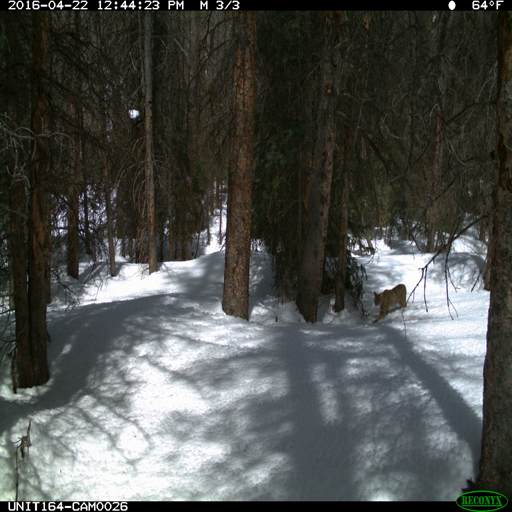

In [47]:
# Example image
img = Image.open('/exchange/dspro01/group3/data/train/bobcat/2015_Unit164_Ivan026_img0171.jpg')
img_small = img.resize((512, 512))
img_small

In [48]:
img_transformed_light = transform_light(img)
img_transformed = transform(img)

def denormalize(tensor):
    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]
    for t, m, s in zip(tensor, mean, std):
        t.mul_(s).add_(m)
    return tensor

to_pil = transforms.ToPILImage()

denormalized_image_light= to_pil(denormalize(img_transformed_light.clone())) # clone copies a new tensor in memory
denormalized_image = to_pil(denormalize(img_transformed.clone()))


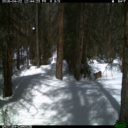

In [49]:
denormalized_image_light

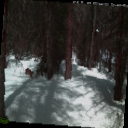

In [50]:
denormalized_image
# Horizontal flip and rotation not necessarily visible cause randomly applied

In [51]:
# For reproducibility of Transformation
seed = 42
torch.manual_seed(seed)

In [52]:
data_dir = '/exchange/dspro01/group3/data/train' 
# dataset = datasets.ImageFolder(root=data_dir, transform=transform) # assigns labels automatically according to folder's name
dataset = datasets.ImageFolder(root=data_dir, transform=transform) # assigns labels automatically according to folder's name
# Normalization independent of dataset so applied at root

In [66]:
num_classes = 12  # number of categories
num_epochs =  2# 25 
learning_rate = 0.001 
batch_size = 32

In [67]:
total_size = len(dataset)
train_size = int(0.8 * total_size)   
val_size = int(0.2 * total_size)     


## Split data

In [68]:
generator = torch.Generator().manual_seed(seed) # For reproducibility
train_dataset, val_dataset = random_split(dataset, [train_size, val_size], generator=generator)
#train_dataset.transform = transform # Transform after split to avoid normalization bias
#val_dataset.transform = transform

In [69]:
len(train_dataset) == (2400 * 12 * 0.8) # Safety check

True

## Load data

In [70]:
# Divides into batches, shuffles data, load in parallel
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=8)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=8)

In [71]:
# Create dataloaders dictionary
dataloaders = {'train': train_loader, 'val': val_loader}


In [72]:
# Create dataset_sizes dictionary for calculating losses and accuracies
dataset_sizes = {'train': len(train_dataset), 'val': len(val_dataset)}

# Model loading and transfer learning

In [73]:
from torchvision import models
import torch.nn as nn

## Load model

In [74]:
model = models.resnet50(pretrained=True)

num_features = model.fc.in_features # Retrieves the number of input features from the current final layer (fc) of the model
model.fc = nn.Linear(num_features, num_classes) # Replaces the existing final layer with a new nn.Linear layer. Full connected - could add more layers

In [75]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss() # Loss function suiting classification problems

optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)  
# Initial learning rate of 0.001
# weight_decay corresponds to the L2 regularization. Prevents overfitting by penalizing large weight values.

scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1) 
# optim = type of learning rate being used
# optimizer = optimizer whose learning rates are being adjusted
# Step size = number of epochs between parameters adjustments
# gamma = The factor by which the learning rate is reduced at each step.

In [76]:
# Move the model to a GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Training & Validation loop

In [77]:
# TODO ADD: classification_report(y_true, y_pred)

In [78]:
from sklearn.metrics import f1_score, confusion_matrix # roc_auc_score,
import numpy as np
import torch

# Initialize metrics storage
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []
val_labels = []
val_predictions = []

# Initialize variables to track the best model
current_time = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
best_val_accuracy = 0.0
best_model_path = f'best_model_{current_time}.pth'


# Track F1, ROC, and confusion matrix
val_f1_scores = []
#val_roc_aucs = []
val_conf_matrices = []

# Early Stopping Parameters
patience = 5  # Number of epochs to wait before stopping
early_stopping_counter = 0  # Counter to track how long since the last improvement
best_epoch = 0  # To track the epoch with the best performance

for epoch in range(num_epochs):
    print(f'Epoch {epoch+1}/{num_epochs}')
    print('-' * 10)
    
    for phase in ['train', 'val']:
        if phase == 'train':
            model.train() # Set model to training mode
        else:
            model.eval()  # Set model to evaluation mode

        running_loss = 0.0
        running_corrects = 0 # number of correct per epoch
        all_preds = []
        all_labels = []

        # Iterate over batches
        for inputs, labels in dataloaders[phase]:
            # Move data to the device GPU
            inputs = inputs.to(device)
            labels = labels.to(device)
            # Resets the gradients of all parameters to zero before the backward pass.
            optimizer.zero_grad()

            # Forward pass    
            with torch.set_grad_enabled(phase == 'train'):# if train phase, set gradient
                outputs = model(inputs) # Passes the input in the Resnet model
                # outputs contains the raw predictions of the model for each input
                
                _, preds = torch.max(outputs, 1)
                # Returns the maximum from the outputs, with dimension 1 and a slot for each class
                # Returns 2 tensors: maximum value and its index
                # _ discards the maximum value 
                # Only the index is kept in preds
                
                loss = criterion(outputs, labels)
                # Computes loss function between outputs and labels
                # Refers to the CrossEntropy loss function defined above

                #  Backpropagation and update the model parameters during training.
                if phase == 'train':
                    loss.backward()
                    optimizer.step() # in which direction to go - -gradient

            # Statistics
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
            all_preds.append(preds.detach().cpu().numpy())
            all_labels.append(labels.detach().cpu().numpy())

        # Convert lists to numpy arrays for metric calculations
        all_preds = np.concatenate(all_preds)
        all_labels = np.concatenate(all_labels)

        epoch_loss = running_loss / dataset_sizes[phase]
        epoch_acc = running_corrects.double() / dataset_sizes[phase]

        print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

        # Store metrics for later plotting
        if phase == 'train':
            train_losses.append(epoch_loss)
            train_accuracies.append(epoch_acc.item())
        else:
            val_predictions.append(all_preds)
            val_labels.append(all_labels)
            val_losses.append(epoch_loss)
            val_accuracies.append(epoch_acc.item())

            # Calculate F1-Score, and confusion matrix for validation phase
            f1 = f1_score(all_labels, all_preds, average='weighted') # from sklearn
            # 'weighted' in case of inbalance dataset or multiclass. Safety here.
            val_f1_scores.append(f1)
            


            # Confusion Matrix
            conf_matrix = confusion_matrix(all_labels, all_preds)
            val_conf_matrices.append(conf_matrix)

            # Save the best model based on validation accuracy
            if epoch_acc > best_val_accuracy:
                best_val_accuracy = epoch_acc
                best_epoch = epoch + 1
                early_stopping_counter = 0  # Reset the counter
                torch.save({
                    'epoch': epoch + 1,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'scheduler_state_dict': scheduler.state_dict(),
                    'accuracy': best_val_accuracy,
                }, best_model_path)
                torch.save(model.state_dict(), f'only_{best_model_path}')
                print(f'Saved best model at epoch {epoch + 1} with validation accuracy: {best_val_accuracy:.4f}')
            else:
                early_stopping_counter += 1  # Increment the counter

    scheduler.step()

    # Check early stopping condition
    if early_stopping_counter >= patience:
        print(f'Early stopping triggered after {epoch + 1} epochs.')
        print(f'Best validation accuracy achieved at epoch {best_epoch}: {best_val_accuracy:.4f}')
        break

print('Training complete')


Epoch 1/2
----------
train Loss: 1.4056 Acc: 0.4970
val Loss: 1.4749 Acc: 0.4804
Saved best model at epoch 1 with validation accuracy: 0.4804
Epoch 2/2
----------
train Loss: 1.0285 Acc: 0.6265
val Loss: 0.9560 Acc: 0.6561
Saved best model at epoch 2 with validation accuracy: 0.6561
Training complete


### Save values

In [82]:
import pandas as pd

# Create a dictionary for data
data = {
    "epoch": range(1, len(train_losses) + 1),  # Epochs start from 1
    "train_loss": train_losses,
    "val_loss": val_losses,
    "train_accuracy": train_accuracies,
    "val_accuracy": val_accuracies,
    "val_f1_score": val_f1_scores,
    "val_conf_matrix": val_conf_matrices,
    "val_labels": val_labels, #
    "val_predictions": val_predictions #
}

# Convert to a DataFrame
df = pd.DataFrame(data)

# Save to a CSV file
file_name = f"training_results_{current_time}.csv"
df.to_csv(file_name, index=False)


# Visualization of training results

In [61]:
len(train_losses)

2

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

stopped_epoch = best_epoch + patience

# Data from your training output
epochs = range(1, stopped_epoch+1) ## HARD CODDED stopped_epoch
           
# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))
fig.suptitle('Training and Validation Metrics', fontsize=16)

# Plot training & validation loss values
ax1.plot(epochs, train_losses, 'b-', label='Training Loss')
ax1.plot(epochs, val_losses, 'r-', label='Validation Loss')
ax1.set_title('Model Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_ylim(0, 3)
ax1.set_xlim(1)
ax1.legend()
ax1.grid()


# Plot training & validation accuracy values
ax2.plot(epochs, train_accuracies, 'b-', label='Training Accuracy')
ax2.plot(epochs, val_accuracies, 'r-', label='Validation Accuracy')
ax2.set_title('Model Accuracy')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.set_ylim(0, 1)
ax2.set_xlim(1)
ax2.set_xticks(ticks=np.arange(1, stopped_epoch + 1, 1)) # HARD CODED, epochs
ax2.legend()
ax2.grid()

# Adjust layout and display the plot
fig.tight_layout()
ax1.plot()
ax2.plot()
fig.show()

# Calculate and print best validation accuracy
best_val_accuracy = max(val_accuracies)
best_epoch = val_accuracies.index(best_val_accuracy) + 1
print(f"Best validation accuracy: {best_val_accuracy:.4f} (Epoch {best_epoch})")

# Calculate and print final training-validation gap
final_train_acc = train_accuracies[-1]
final_val_acc = val_accuracies[-1]
acc_gap = final_train_acc - final_val_acc
print(f"Final accuracy gap (train - val): {acc_gap:.4f}")


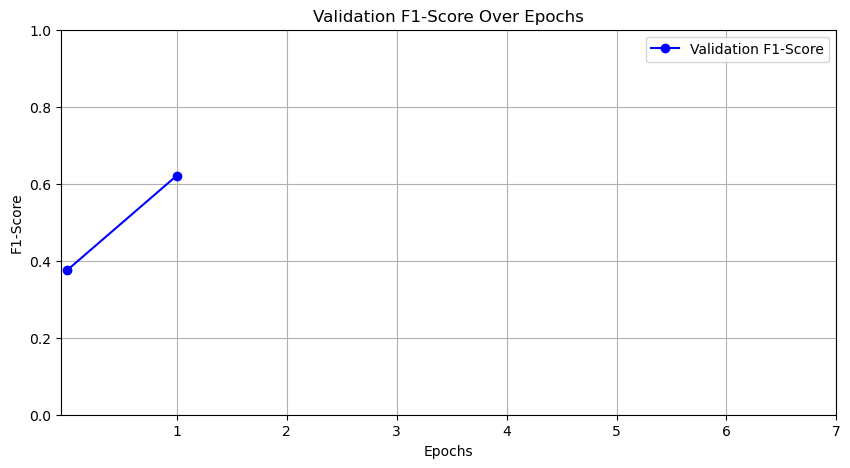

In [63]:
# Plot F1-Score
f, ax = plt.subplots(figsize=(10, 5), sharex=True)
ax.plot(val_f1_scores, label='Validation F1-Score', marker='o', color='blue')
ax.set_xlabel('Epochs', loc='center')
ax.set_ylabel('F1-Score')
ax.set_title('Validation F1-Score Over Epochs')
ax.set_ylim(0, 1)
ax.set_xticks(ticks=np.arange(1, stopped_epoch + 1, 1)) # HARD CODED
ax.legend()
ax.grid()
f.show()

2


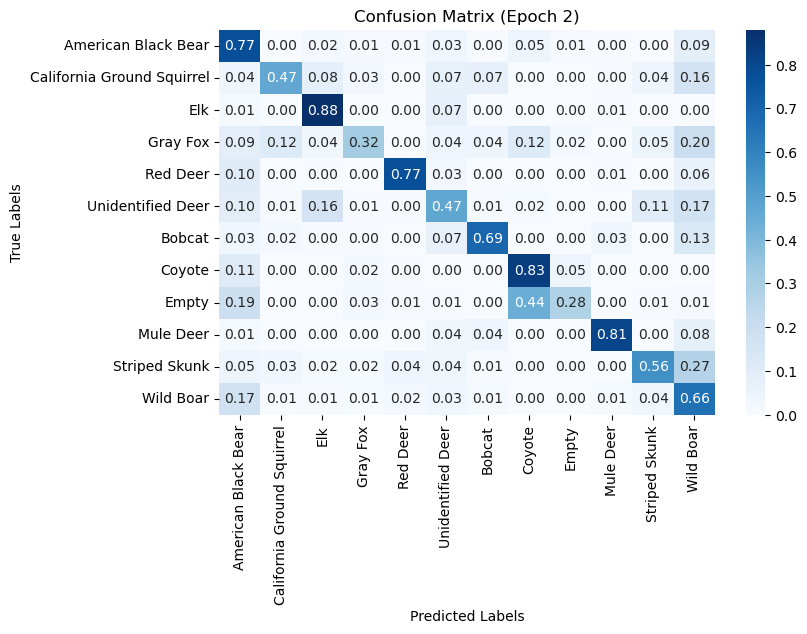

In [82]:
import seaborn as sns
print(best_epoch)
# Confusion Matrix for the Best Epoch
conf_matrix = val_conf_matrices[best_epoch - 1]  # Index corresponds to the best epoch
class_names = ['American Black Bear', 'California Ground Squirrel', 'Elk', 'Gray Fox', 'Red Deer', 'Unidentified Deer', 'Bobcat', 'Coyote', 'Empty', 'Mule Deer', 'Striped Skunk', 'Wild Boar']  # TODO CLASSES NAMES

f, ax = plt.subplots(figsize=(8, 5), sharex=True)
sns.heatmap(conf_matrix/ (len(val_dataset)/num_classes), annot=True, fmt='.2f', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
ax.set_xlabel('Predicted Labels')
ax.set_ylabel('True Labels')
ax.set_title(f'Confusion Matrix (Epoch {best_epoch})')
f.show()


# Testing REVOIR

Test set contains 600 pictures per category

In [21]:
test_dataset = datasets.ImageFolder(root='/exchange/dspro01/group3/data/test', transform=transform) # same transform as train and validation phases
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

Attempt with portion of the test set

In [32]:
from torch.utils.data import Subset

# Create a subset of the first 3 images
subset_indices = list(range(50))  # Indices of the first 3 images
test_subset = Subset(test_dataset, subset_indices)

# Create a DataLoader for the subset
test_loader_subset = DataLoader(test_subset, batch_size=batch_size, shuffle=False)


In [23]:
import torch
import torchvision.models as models
import torch.nn as nn
best_model_only = 'only_best_model_2024-12-30_14-32-31.pth'
# Load the pre-trained ResNet model
model = models.resnet50(pretrained=False)

# Modify the 'fc' layer to have 12 output classes
model.fc = nn.Linear(model.fc.in_features, 12)

# Load the state_dict
model.load_state_dict(torch.load(best_model_only, map_location=torch.device('cpu')))  # Use 'cuda' if testing on GPU

model.eval()


/opt/conda/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [24]:
image_path = '/exchange/dspro01/group3/data/test/bobcat/2015_Unit097_Ivan076_img0742.jpg'
#image_path = '/exchange/dspro01/group3/data/test/gray fox/CA-01_08_13_2015_CA-01_0001873.jpg'
image = Image.open(image_path).convert('RGB') 
input_tensor = transform(image).unsqueeze(0) # Add batch dimension

In [34]:
class_names = ['American Black Bear', 'California Ground Squirrel', 
               'Elk', 'Gray Fox', 'Red Deer', 'Unidentified Deer', 
               'Bobcat', 'Coyote', 'Empty', 'Mule Deer', 
               'Striped Skunk', 'Wild Boar']
class_mapping = {i: class_names[i] for i in range(12)}

# Perform inference
with torch.no_grad():  # Disable gradient computation for inference
    output = model(input_tensor)  # Forward pass
    predicted_class = torch.argmax(output, dim=1).item()  # Get the predicted class index

print(f"Predicted class: {predicted_class}")
print(f"Predicted class name: {class_mapping[predicted_class]}")


Predicted class: 7
Predicted class name: Coyote


In [29]:
all_labels = []
all_predictions = []

with torch.no_grad():  # Disable gradient computation
    for inputs, labels in test_loader_subset:
        print('Loop start')
        outputs = model(inputs)  # Get model predictions
        print('Output calculated')
        predicted = torch.argmax(outputs, dim=1)  # Predicted class indices
        print('Prediction calculated')
        # Store real labels and predictions
        all_labels.extend(labels.numpy())  # Extend with all labels in the batch
        print('label added')
        all_predictions.extend(predicted.numpy())  
        print('prediction added')
    print('Testing done.')

Loop start
Output calculated
Prediction calculated
label added
prediction added
Testing done.


In [31]:
print(all_labels[0])
print(all_labels[1])
print(len(all_labels), len(all_predictions))

0
0
6 6


In [35]:
import numpy as np
all_labels = np.array(all_labels)
all_predictions = np.array(all_predictions)
accuracy = np.mean(all_labels == all_predictions)
print(f"Accuracy on the test set: {accuracy * 100:.2f}%")

#Plot precision for the first images
for i in range(3):
    print(f"True label: {class_mapping[all_labels[i]]}, Predicted: {class_mapping[all_predictions[i]]}")


Accuracy on the test set: 83.33%
True label: American Black Bear, Predicted: American Black Bear
True label: American Black Bear, Predicted: American Black Bear
True label: American Black Bear, Predicted: American Black Bear


# Attempt to identify misclassification

In [ ]:
misclassified_indices = []
misclassified_files = [] 
all_labels = []
all_predictions = []

with torch.no_grad():  # Disable gradient computation
    for inputs, labels in test_loader_subset:
        print('Loop start')
        outputs = model(inputs)  # Get model predictions
        predicted = torch.argmax(outputs, dim=1)  # Predicted class indices
        # Store real labels and predictions
        all_labels.extend(labels.numpy())  # Extend with all labels in the batch
        print('label added')
        all_predictions.extend(predicted.numpy())  
        print('prediction added')
    print('Testing done.')

with torch.no_grad():  # Disable gradient computation
    for batch_idx, (inputs, labels) in enumerate(test_loader_subset):
        outputs = model(inputs)  # Get model predictions
        predicted = torch.argmax(outputs, dim=1)  # Predicted class indices
        
        # Find mismatches
        mismatches = (predicted != labels)  # Boolean tensor of mismatches
        mismatch_indices = torch.where(mismatches)[0]  # Indices in the batch
        
        # Add indices or filenames of misclassified images
        for idx in mismatch_indices:
            global_idx = batch_idx * test_loader_subset.batch_size + idx.item()  # Adjust for batch offset
            misclassified_indices.append(global_idx)
            
            # If dataset provides filenames, retrieve them
            if hasattr(test_loader_subset.dataset, "files"):  # Example attribute for filenames
                misclassified_files.append(test_loader_subset.dataset.files[global_idx])


In [ ]:
# run it and check accuracy, without changing any weight

# then change one layer (new notebook)
# Then with maybe 3 layers

# usually dense layers in the end
# cause cnn for extracting features instead

In [ ]:
# if hyperparameters --> e.g. change number of neurons and find the best model